# 자율주행 보조장치

### 자율주행 보조장치 object detection 요구사항

1) 사람이 감지되면 정지   
2) 차량이 일정 크기 이상으로 감지되면 정지

## (1) KITTI 데이터셋

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv('HOME'), 'aiffel/Going_Deeper/4.object_detection/data')

(ds_train, ds_test), ds_info = tfds.load('kitti',
                                        data_dir = data_dir,
                                        split = ['train', 'test'],
                                        shuffle_files = True,
                                        with_info = True
                                        )

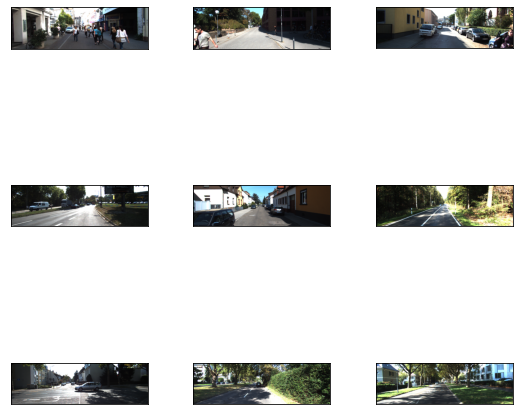

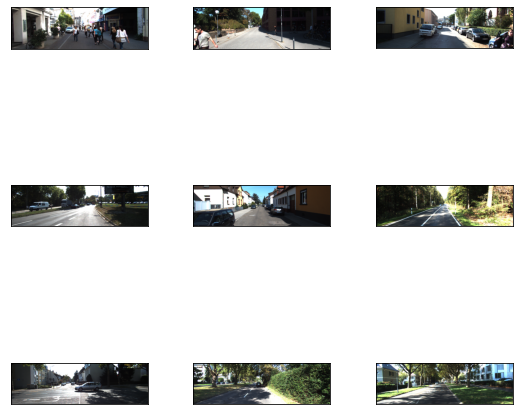

In [3]:
tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/Going_Deeper/4.object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf

## (2) 데이터 직접 확인하기

--------Example--------
['image', 'image/file_name', 'objects']
---------------------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.40194666, 0.398438  , 0.5124533 , 0.4485185 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.48, 1.87, 4.42]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-3.27,  1.89, 28.56]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.59], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


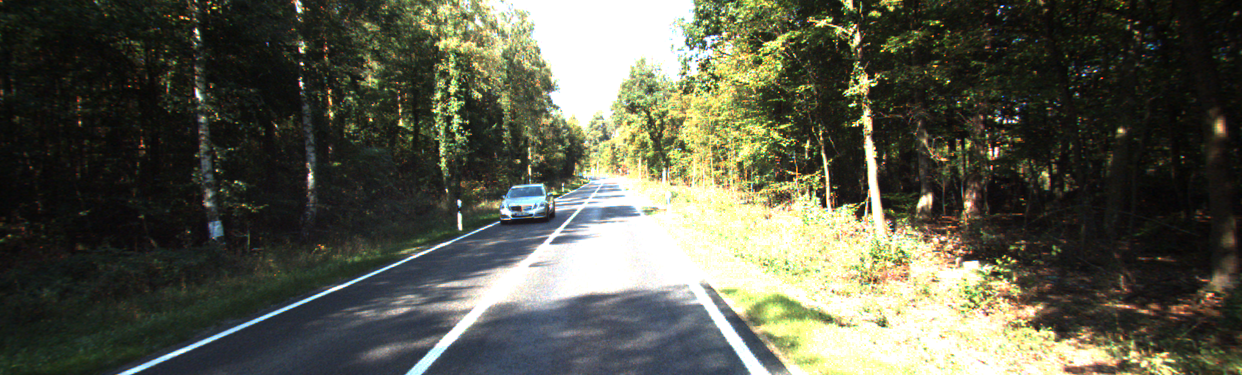

In [5]:
sample = ds_train.take(1)

for example in sample:
    print('--------Example--------')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('---------------------')
print(objects)

img = Image.fromarray(image.numpy())
img

-이미지 위에 바운딩 박스를 그려서 시각화

width :  1242 height :  375
(1, 4)
[494.86002 224.27    557.06    182.83   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F51A013C610>


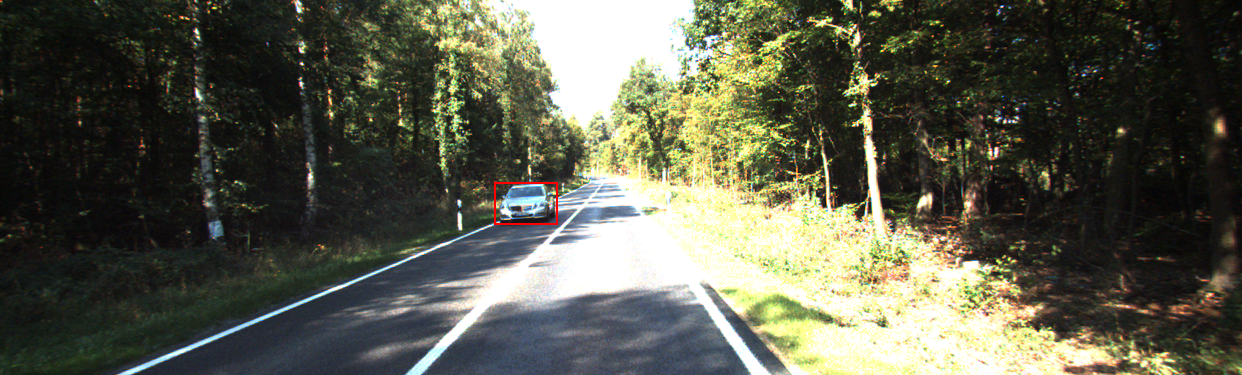

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    #bbox 좌표 구하기
    width, height = img.size
    print('width : ', width, 'height : ', height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    #bbox 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for rect in rects:
        print(rect)
        draw.rectangle(rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image
    
visualize_bbox(img, objects['bbox'].numpy())

## RetinaNet

https://arxiv.org/pdf/1708.02002.pdf

1-stage detector 모델인 YOLO, SSD는 2-stage detector 모델인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있다. 이를 해결하기 위해 RetinaNet에서는 focal loss와 FPN을 적용한 네트워크를 사용한다.

#### Focal loss
- 기존 1-stage detection 모델을이 물체 전경과 배경을 담고 있는 모든 그리드에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입.   
   
- 대부분의 이미지는 물체보다 배경이 많다. 이런 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절한다.

#### FPN (Feature Pyramid Network)

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식이다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 feature map으로 사용할 수 있다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 셀이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일 수록 좁은 범위의 정보를 담고 있다. 이를 receptive field라고 한다. 레이어가 깊어질수록 pooling을 거쳐 넓은 범위의 정보를 갖게 되는 것이다.   
   
   
FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 unsampling(확대) 하여 앞단의 특성 맵과 더해서 사용했다. 즉 레이어가 깊어질수록 feature map의 w,h 방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 것이다.   

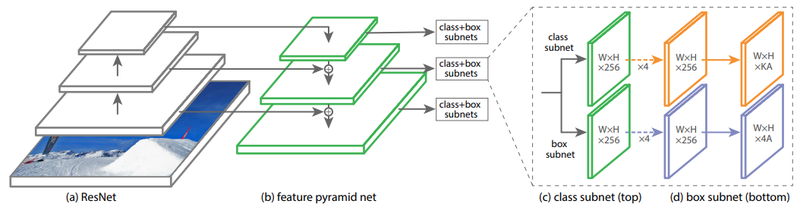

# Keras-retinanet

#### (1) 데이터 포맷 변경

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일 작성하는 코드

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/Going_Deeper/4.object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인
    # 기존의 class를 차와 사람으로 나눔
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [24:37<00:00,  4.30it/s]


- 테스트 데이터셋에도 parse_dataset() 적용

In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:51<00:00,  4.14it/s]


- 클래스 mapping : 데이터셋에서 클래스는 문자로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 한다.   

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


#### (2) 셋팅

In [10]:
# RetinaNet 훈련 시작
%cd ~/aiffel/Going_Deeper/4.object_detection/keras-retinanet
!pip install -r requirements.txt
!pip install .

!cd ~/aiffel/Going_Deeper/4.object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt

/aiffel/aiffel/Going_Deeper/4.object_detection/keras-retinanet
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8b3dpsbt
     |████████████████████████████████| 1.9 MB 5.8 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.7 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-req-build-8b3dpsbt/PythonAPI/setup.py'"'"'; __file__='"'"'/tmp/pip-req-build-8b3dpsbt/PythonAPI/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-gcjtgsbt
       cwd: /tmp/pip-req-build-8b3dpsbt/PythonAPI
  Complete output (63 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.7
  creating build/lib.linux-x86_64-3.7/pycocotools
  copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.7/pycocotools
  

In [11]:
!cd ~/aiffel/Going_Deeper/4.object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-12-31 04:29:00.863557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-31 04:29:02.693769: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-31 04:29:02.694801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-31 04:29:02.719093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 04:29:02.719931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-31 04:29:02.719983: I tensorflow/stream_executor/platform/default/dso_lo

#### (3) 시각화

In [13]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/Going_Deeper/4.object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[186.4229  131.99797 357.82474 236.97449]
[592.79834 175.024   625.75903 208.34766]
[370.28293 182.84198 418.41898 210.34358]
[531.4912  159.63483 562.6989  191.69196]


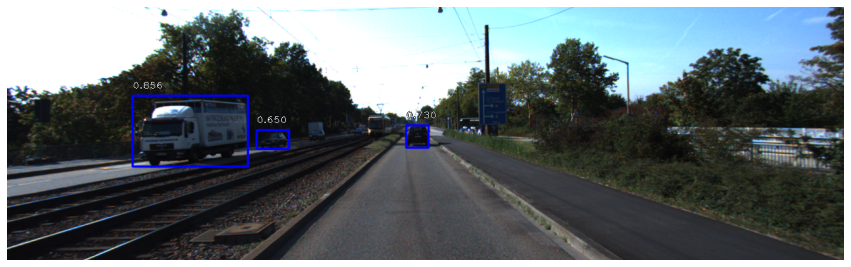

In [14]:
import os
img_path = os.getenv('HOME')+'/aiffel/Going_Deeper/4.object_detection/test_set/go_1.png'

def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[760.5893  146.96533 845.01984 317.33398]
[759.3665  149.31108 849.17566 310.74072]


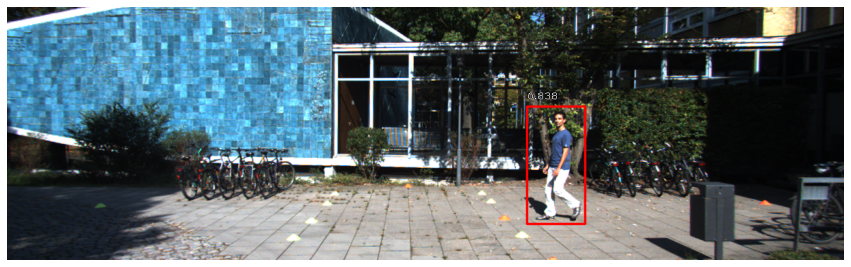

In [15]:
img_path = os.getenv('HOME')+'/aiffel/Going_Deeper/4.object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

### 프로젝트 : 자율주행 보조 시스템 만들기

- 입력으로 이미지 경로를 받는다.
- 정지 조건에 맞는 경우 'Stop', 아닌 경우 'Go' 반환
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기가 300px 이상인 경우

In [19]:
img_path = os.getenv('HOME')+'/aiffel/Going_Deeper/4.object_detection/test_set/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # 만약 사람이 1명 이상이면 멈춘다.
        if label == 1:
            return "Stop"
        
        elif label == 0:
            width = box[2] - box[0]
            height = box[3] - box[1]
            # 사람이 아닌 경우 width와 height 둘 중 하나가 300 이상이면 'Stop'
            if width > 300 or height > 300:
                return "Stop"
        # 둘다 아니라면 그냥 간다.    
        if score < 0.5:
            return "Go"

print(self_drive_assist(img_path)) 

Stop


In [20]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/Going_Deeper/4.object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.
